In [1]:
import numpy as np, json, matplotlib,  pandas as pd, seaborn as sn
from datetime import datetime
from conceptual_engineering_assistant import Concept, ConceptualEngineeringAssistant
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import WikipediaLoader

In [2]:
SAMPLE_SIZE = 4
females = np.random.choice(json.load(open('data/females-2023-03-15.json', 'r')), SAMPLE_SIZE)
males = np.random.choice(json.load(open('data/males-2023-03-15.json', 'r')), SAMPLE_SIZE)
non_binaries = np.random.choice(json.load(open('data/non-binaries-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_men = np.random.choice(json.load(open('data/trans-men-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_women = np.random.choice(json.load(open('data/trans-women-2023-03-15.json', 'r')), SAMPLE_SIZE)
sample = np.concatenate((females, trans_women, non_binaries, trans_men, males))

In [3]:
for entity in sample:
    entity["description"] = WikipediaLoader(query=entity["name"], load_max_docs=1).load()[0].page_content[:400]

In [4]:
entities = pd.DataFrame.from_records(sample)
entities

,item,name,article,gender,description
0,http://www.wikidata.org/entity/Q66525,Auguste von Harrach,https://en.wikipedia.org/wiki/Auguste_von_Harrach,female,Countess Auguste von Harrach zu Rohrau und Tha...
1,http://www.wikidata.org/entity/Q11615,Sheila Greibach,https://en.wikipedia.org/wiki/Sheila_Greibach,female,Sheila Adele Greibach (born 6 October 1939 in ...
2,http://www.wikidata.org/entity/Q78590,Maria Jeritza,https://en.wikipedia.org/wiki/Maria_Jeritza,female,Maria Jeritza (born Marie Jedličková; 6 Octobe...
3,http://www.wikidata.org/entity/Q14232,Jean E. Sammet,https://en.wikipedia.org/wiki/Jean_E._Sammet,female,"Jean E. Sammet (March 23, 1928 – May 20, 2017)..."
4,http://www.wikidata.org/entity/Q42297595,Ines Rau,https://en.wikipedia.org/wiki/Ines_Rau,trans woman,Ines-Loan Rau (born 1990) is a French model. S...
5,http://www.wikidata.org/entity/Q711397,Philippa York,https://en.wikipedia.org/wiki/Philippa_York,trans woman,Philippa York (born Robert Millar on 13 Septem...
6,http://www.wikidata.org/entity/Q13560362,Harmony Santana,https://en.wikipedia.org/wiki/Harmony_Santana,trans woman,Harmony Santana is an American film actress. S...
7,http://www.wikidata.org/entity/Q63184799,Stephanie Yellowhair,https://en.wikipedia.org/wiki/Stephanie_Yellow...,trans woman,"Stephanie Yellowhair (December 13, 1976 – Marc..."
8,http://www.wikidata.org/entity/Q7681866,Tamsin Omond,https://en.wikipedia.org/wiki/Tamsin_Omond,non-binary,Tamsin Omond (born 19 November 1984) is a Brit...
9,http://www.wikidata.org/entity/Q219368,Judith Butler,https://en.wikipedia.org/wiki/Judith_Butler,non-binary,"Judith Pamela Butler (born February 24, 1956) ..."


In [5]:
oed_woman = Concept("oed_woman", "woman", "An adult female human being. The counterpart of man (see man, n.¹ II.4.)")

In [6]:
haslanger_woman = Concept("haslanger_woman", "woman", """S is a woman iff (i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination""")

In [7]:
homosaurus_woman = Concept("homosaurus_woman", "woman", """Adults who self-identify as women and understand their gender in terms of Western conceptions of 
womanness, femaleness, and/or femininity. The term has typically been defined as adult female humans, though not all women identify with 
the term "female" depending on the context in which it is used.""")

In [8]:
cea = ConceptualEngineeringAssistant()

In [9]:
oed_classifications = pd.DataFrame( 
    [ cea.classify_entity(oed_woman, entity["name"], entity["description"]) for entity in sample ], 
    columns = [ 'entity' , 'in_extension', 'rationale' ] 
    )

In [10]:
oed_results = pd.concat([entities[["name", "gender"]], oed_classifications[["in_extension", "rationale"]]], axis=1)
results_styler = oed_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,in_extension,rationale
0,Auguste von Harrach,female,True,"Auguste von Harrach is described as the second spouse of King Frederick William III of Prussia, which indicates that she is an adult female human being. Therefore, according to the provided definition, she is a woman."
1,Sheila Greibach,female,True,"The description provides information that Sheila Greibach is a female. Given the definition of 'woman' as an adult female human being, it can be concluded that Sheila Greibach is a woman."
2,Maria Jeritza,female,True,"Maria Jeritza is described as a female human being, which aligns with the definition of a woman. Therefore, it is true that Maria Jeritza is a woman."
3,Jean E. Sammet,female,True,"The text identifies Jean E. Sammet as a female. According to the provided definition, a woman is an adult female human being. Therefore, it is true that Jean E. Sammet is a woman."
4,Ines Rau,trans woman,True,"Ines Rau is considered a woman because she transitioned and underwent gender-affirming surgery. She identifies and lives as a woman, which aligns with the definition of a woman as an adult female human being."
5,Philippa York,trans woman,True,"Philippa York was born as Robert Millar, indicating she is a transgender woman. According to the definition provided, a woman is an adult female human being. Therefore, as Philippa identifies as a woman, she is considered a woman."
6,Harmony Santana,trans woman,True,"Harmony Santana is identified as a woman. She is an adult, a human being, and identifies as female. Therefore, she fits the definition of a woman. Her being transgender does not change this, as transgender women are women."
7,Stephanie Yellowhair,trans woman,True,"Stephanie Yellowhair is considered a woman because she identified as a transgender woman. Being a woman is not solely determined by biological sex, but also by gender identity. Therefore, even though she might have been assigned male at birth, her identification as a woman makes her a woman."
8,Tamsin Omond,non-binary,Unknown,"The text does not provide specific information about Tamsin Omond's gender. While the name ""Tamsin"" is traditionally female, the text uses gender-neutral pronouns (""they""), so we cannot definitively determine whether Tamsin Omond identifies as a woman."
9,Judith Butler,non-binary,True,"Judith Butler is identified as an adult female human being, which aligns with the definition of a woman. Therefore, it is true that Judith Butler is a woman."


In [11]:
haslanger_classifications = pd.DataFrame( 
    [ cea.classify_entity(haslanger_woman, entity["name"], entity["description"]) for entity in sample ], 
    columns = [ 'entity' , 'in_extension', 'rationale' ] 
    )

In [12]:
haslanger_results = pd.concat([entities[["name", "gender"]], haslanger_classifications[["in_extension", "rationale"]]], axis=1)
results_styler = haslanger_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,in_extension,rationale
0,Auguste von Harrach,female,True,"Auguste von Harrach satisfies the definition of a woman as she is biologically female, which is indicated by the use of female pronouns in the description. Additionally, she occupied a social position that was subordinate, as she was the spouse of King Frederick William III of Prussia, indicating that she was expected to fulfill certain societal roles. Furthermore, her family was not initially recognized as equal for dynastic purposes, suggesting that she experienced some form of systematic subordination. Therefore, according to the provided definition, Auguste von Harrach is a woman."
1,Sheila Greibach,female,True,"Sheila Greibach is identified as a female based on her name and pronouns. She is likely observed to have the bodily features associated with females, marking her within the dominant ideology of her society as someone who ought to occupy certain kinds of social position. Even though her position as a researcher and professor is not subordinate, women in general are often systematically subordinated in society, and her being a woman plays a role in that dimension of subordination. Therefore, according to the provided definition, Sheila Greibach is a woman."
2,Maria Jeritza,female,True,"Maria Jeritza is identified as a woman because she is referred to with female pronouns and her biography does not suggest that she identifies otherwise. She is also likely to have been observed or imagined to have certain bodily features associated with the female biological role in reproduction, given the time and place she lived. Furthermore, as a soprano singer, she occupied a social position that was likely considered appropriate for women in her society. Lastly, it can be inferred that her gender played a role in her social position and potentially her subordination, given the societal norms and gender roles of her time."
3,Jean E. Sammet,female,True,"Jean E. Sammet fits the definition of a woman because she is observed to have the bodily features associated with a female's biological role in reproduction (as indicated by the use of female pronouns in the description). Additionally, as a woman in the male-dominated field of computer science during the mid-20th century, she likely occupied a social position that was subordinate to her male counterparts, satisfying condition (ii). The fact that she was a woman in this field may have contributed to her systematic subordination, satisfying condition (iii). Therefore, according to the provided definition, Jean E. Sammet is a woman."
4,Ines Rau,trans woman,True,"Ines Rau meets the criteria of the definition provided for a woman. She is observed and imagined to have certain bodily features presumed to be evidence of a female’s biological role in reproduction, especially after her gender-affirming surgery. She is marked within the dominant ideology of her society as someone who ought to occupy certain kinds of social position that are in fact subordinate, as evidenced by her career as a model, a profession often associated with women. The fact that she satisfies these conditions plays a role in her systematic subordination, as she is a transgender woman in a society that often marginalizes and oppresses transgender individuals."
5,Philippa York,trans woman,True,"Philippa York, formerly known as Robert Millar, is identified as a woman. She presumably has the bodily features associated with being a woman, as per part (i) of the definition. As a woman in society, she would be subject to the same societal expectations and potential subordination as other women, satisfying parts (ii) and (iii) of the definition. Therefore, according to the provided definition, Philippa York is a woman."
6,Harmony Santana,trans woman,True,"Harmony Santana is considered a woman based on the provided definition. She is observed and imagined to have certain bodily features associated with a female's biological role in reproduction, as she is a 

In [13]:
homosaurus_classifications = pd.DataFrame( 
    [ cea.classify_entity(homosaurus_woman, entity["name"], entity["description"]) for entity in sample ], 
    columns = [ 'entity' , 'in_extension', 'rationale' ] 
    )

In [14]:
homosaurus_results = pd.concat([entities[["name", "gender"]], homosaurus_classifications[["in_extension", "rationale"]]], axis=1)
results_styler = homosaurus_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,in_extension,rationale
0,Auguste von Harrach,female,True,"Auguste von Harrach is identified as a woman because she is an adult who presumably identified as a woman and understood her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. She was also referred to as the spouse of King Frederick William III of Prussia, which typically implies a female gender in a traditional Western context."
1,Sheila Greibach,female,True,"The entity description for Sheila Greibach indicates that she is referred to with female pronouns, suggesting that she identifies as a woman. Furthermore, there is no information suggesting that she does not identify with the term ""woman"" or ""female"". Therefore, based on the provided definition of a woman, it can be concluded that Sheila Greibach is a woman."
2,Maria Jeritza,female,True,"Maria Jeritza is considered a woman because she is an adult who presumably identified as a woman, given the context of her time and her career as a soprano singer. She is also referred to with female pronouns in the text, further suggesting that she identifies as a woman."
3,Jean E. Sammet,female,True,"Jean E. Sammet is considered a woman based on the provided definition. She is an adult who presumably self-identifies as a woman, and she is referred to with female pronouns in the description. Furthermore, she is understood in terms of Western conceptions of womanness, femaleness, and femininity."
4,Ines Rau,trans woman,True,"Ines Rau self-identifies as a woman and has undergone gender-affirming surgery. She understands her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. Therefore, according to the provided definition, Ines Rau is a woman."
5,Philippa York,trans woman,True,"Philippa York, although born as Robert Millar, is identified as a woman. This is in line with the definition provided which states that a woman is an adult who self-identifies as a woman. Therefore, Philippa York is a woman."
6,Harmony Santana,trans woman,True,"Harmony Santana self-identifies as a woman and is recognized as a woman in her professional field, aligning with the given definition of the term ""woman"". She is also noted as being a transgender woman, further supporting her identification as a woman."
7,Stephanie Yellowhair,trans woman,True,"Stephanie Yellowhair is considered a woman based on the provided definition because she was a transgender activist, implying that she identified as a woman. The definition includes those who self-identify as women, which would encompass transgender women like Stephanie Yellowhair."
8,Tamsin Omond,non-binary,Unknown,"The text does not provide information on how Tamsin Omond self-identifies in terms of gender. While they are referred to with 'they' pronouns, this does not definitively indicate their gender identity. Therefore, it is unknown whether Tamsin Omond identifies as a woman."
9,Judith Butler,non-binary,True,"Judith Butler is considered a woman based on the provided definition. She self-identifies as a woman and understands her gender in terms of Western conceptions of womanness, femaleness, and/or femininity. Furthermore, she has significantly contributed to the fields of feminism and gender studies, which further aligns with the definition provided."


In [15]:
def confusion_matrix(results):
    return results[["gender", "in_extension"]].groupby(['gender','in_extension'], sort=False).size().unstack(fill_value=0)[["True", "Unknown", "False"]]

<Axes: xlabel='in_extension', ylabel='gender'>

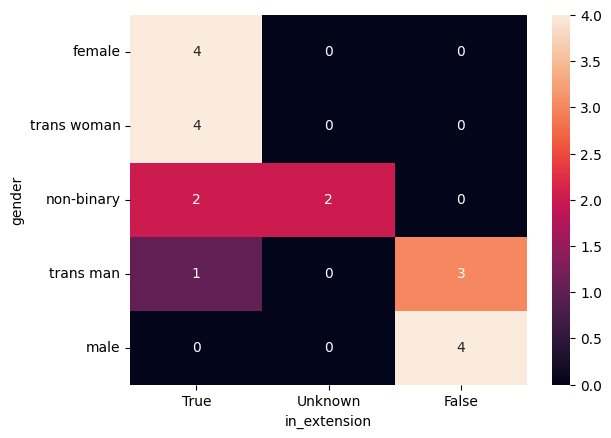

In [16]:
sn.heatmap(confusion_matrix(oed_results), annot=True)

<Axes: xlabel='in_extension', ylabel='gender'>

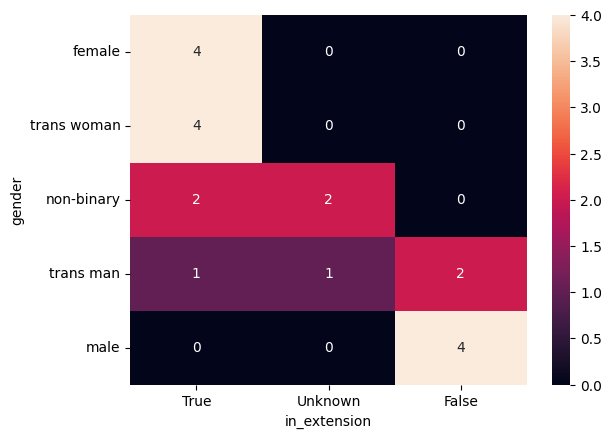

In [17]:
sn.heatmap(confusion_matrix(haslanger_results), annot=True)

<Axes: xlabel='in_extension', ylabel='gender'>

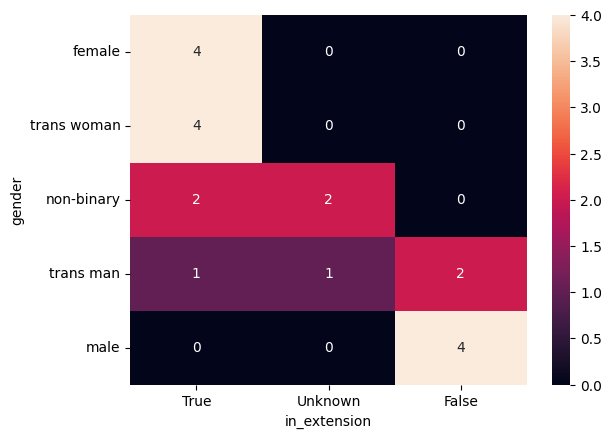

In [18]:
sn.heatmap(confusion_matrix(homosaurus_results), annot=True)

In [19]:
def evaluation_record(model, concept, data):
    return {
        "created": datetime.now().isoformat(),
        "model": {
            "name": cea.model_name,
            "temperature": cea.temperature,
        },
        "concept": {
            "id": concept.id,
            "term": concept.term,
            "definition": concept.definition,
        },
        "data": data.to_dict('records'),
    }

In [20]:
oed_evaluation_record = evaluation_record(cea, oed_woman, pd.concat([entities, oed_classifications], axis=1))
haslanger_evaluation_record = evaluation_record(cea, haslanger_woman, pd.concat([entities, haslanger_classifications], axis=1))
homosaurus_evaluation_record = evaluation_record(cea, homosaurus_woman, pd.concat([entities, homosaurus_classifications], axis=1))
json.dump(
    oed_evaluation_record, 
    open(f'data/{oed_evaluation_record["model"]["name"]}_{oed_evaluation_record["concept"]["id"]}_{oed_evaluation_record["created"]}.json', 'w')
)
json.dump(
    haslanger_evaluation_record, 
    open(f'data/{haslanger_evaluation_record["model"]["name"]}_{haslanger_evaluation_record["concept"]["id"]}_{haslanger_evaluation_record["created"]}.json', 'w')
)
json.dump(
    homosaurus_evaluation_record, 
    open(f'data/{homosaurus_evaluation_record["model"]["name"]}_{homosaurus_evaluation_record["concept"]["id"]}_{homosaurus_evaluation_record["created"]}.json', 'w')
)